In [1]:
import math
import numpy as np
import pandas as pd

import datashader as ds
import datashader.transfer_functions as tf
from datashader.layout import random_layout, circular_layout, forceatlas2_layout
from datashader.bundling import connect_edges, hammer_bundle

from itertools import chain

In [2]:
np.random.seed(0)
n=100
m=20000

nodes = pd.DataFrame(["node"+str(i) for i in range(n)], columns=['name'])
nodes.tail()

,name
95,node95
96,node96
97,node97
98,node98
99,node99


In [3]:
edges = pd.DataFrame(np.random.randint(0,len(nodes), size=(m, 2)),
                     columns=['source', 'target'])
edges.tail()

,source,target
19995,95,22
19996,16,17
19997,10,17
19998,61,69
19999,56,23


In [4]:
circular  = circular_layout(nodes, uniform=False)
randomloc = random_layout(nodes)
randomloc.tail()

,name,x,y
95,node95,0.301081,0.466389
96,node96,0.830928,0.560088
97,node97,0.598997,0.248557
98,node98,0.484809,0.084411
99,node99,0.638193,0.083431


In [5]:
cvsopts = dict(plot_height=600, plot_width=800)


def nodesplot(nodes, name=None, canvas=None, cat=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    aggregator=None if cat is None else ds.count_cat(cat)
    agg=canvas.points(nodes,'x','y',aggregator)
    return tf.spread(tf.shade(agg, cmap=["#FF3333"]), px=3, name=name)

ForceAtlas2 layout

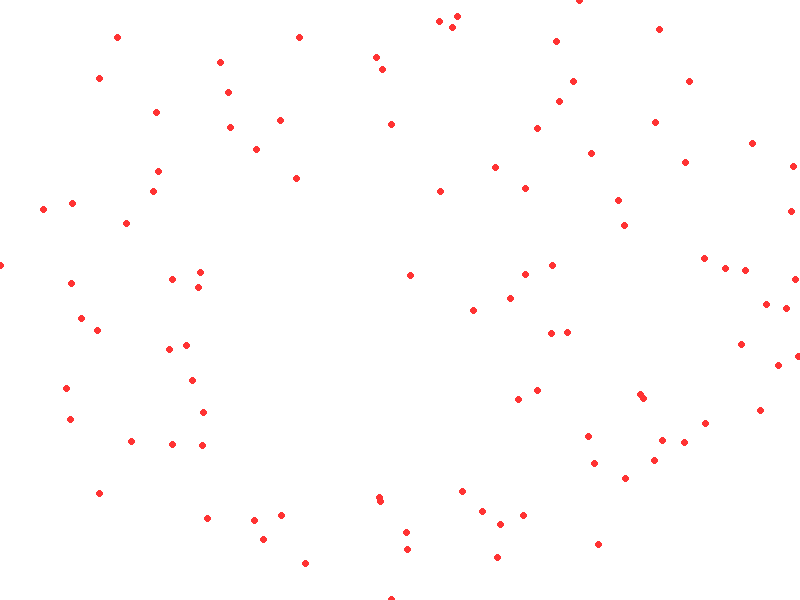

In [6]:
forcedirected = forceatlas2_layout(nodes, edges)
tf.Images(nodesplot(forcedirected, "ForceAtlas2 layout"))

In [7]:
def edgesplot(edges, name=None, canvas=None):
    canvas = ds.Canvas(**cvsopts) if canvas is None else canvas
    return tf.shade(canvas.line(edges, 'x','y', agg=ds.count()), name=name)
    
def graphplot(nodes, edges, name="", canvas=None, cat=None):
    if canvas is None:
        xr = nodes.x.min(), nodes.x.max()
        yr = nodes.y.min(), nodes.y.max()
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
        
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    #print(np)
    ep = edgesplot(edges, name + " edges", canvas)
    #print(ep)
    return tf.stack(ep, np, how="over", name=name)

CPU times: user 1.26 s, sys: 761 µs, total: 1.26 s
Wall time: 1.25 s


""

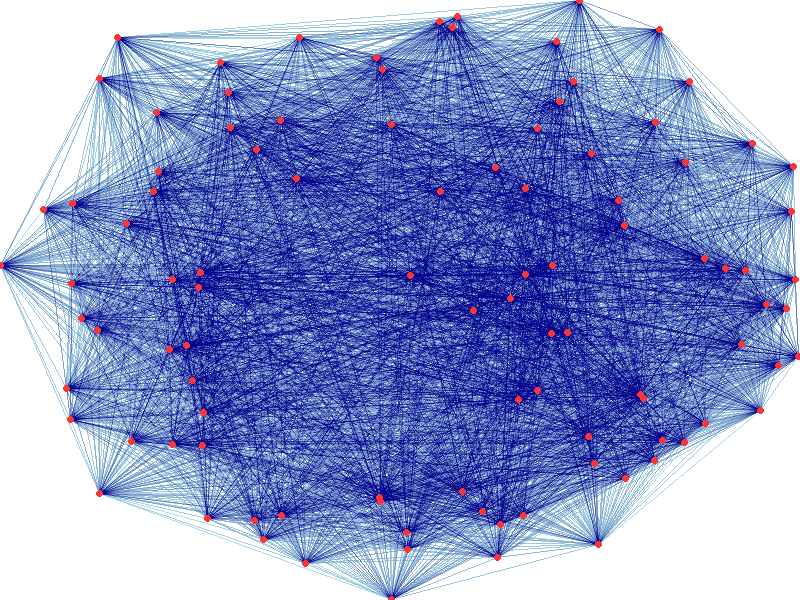

In [8]:
#cd = circular
fd = forcedirected

#%time cd_d = graphplot(cd, connect_edges(cd,edges), "Circular layout")
%time fd_d = graphplot(fd, connect_edges(fd,edges)) 
#%time cd_b = graphplot(cd, hammer_bundle(cd,edges), "Circular layout, bundled")
#%time fd_b = graphplot(fd, hammer_bundle(fd,edges), "Force-directed, bundled") 

tf.Images(fd_d)

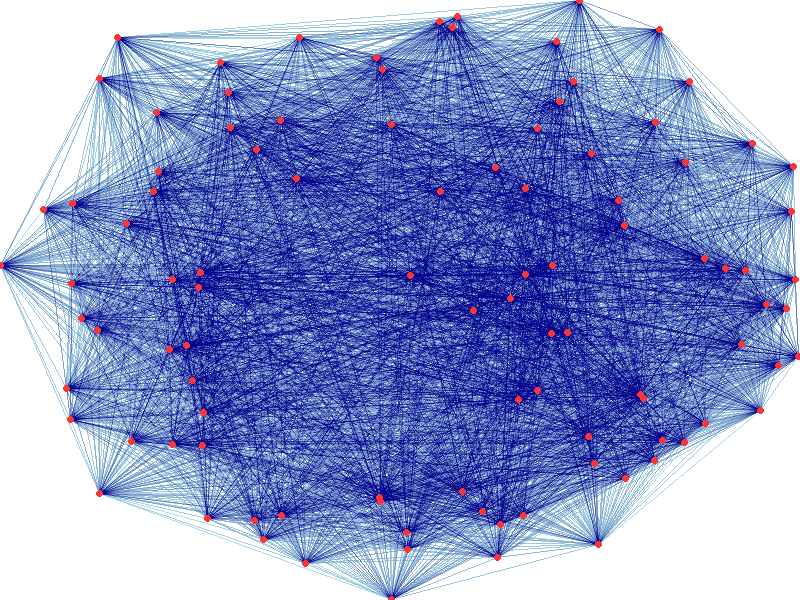

In [9]:
back_img = tf.Image(fd_d).to_pil()
back_img

In [17]:
x_range=fd.x.min(), fd.x.max()
y_range=fd.y.min(), fd.y.max()

#xr = nodes.x.min(), nodes.x.max()
#yr = nodes.y.min(), nodes.y.max()
plot_height=600
plot_width=800

mapbox_access_token = 'pk.eyJ1IjoiZWp0YWxib3QiLCJhIjoiY2ptMHBlOGdjMmZlaTNwb2dwMHE2Mm54NCJ9.xzceVNmAZy49SyFDb3UMaw'

import plotly.graph_objs as go
f = go.FigureWidget(data=[{'x': x_range, 
                           'y': y_range, 
                           'mode': 'markers',
                           'marker': {'opacity': 0}}], # invisible trace to init axes and to support autoresize
                    layout={'width': plot_width, 
                            'height': plot_height}
                   )

f.layout.images = [go.layout.Image(
    source = back_img,  # plotly now performs auto conversion of PIL image to png data URI
    xref = "x",
    yref = "y",
    x = x_range[0],
    y = y_range[1],
    sizex = x_range[1] - x_range[0],
    sizey = y_range[1] - y_range[0],
    #sizing = "stretch",
    layer = "below")]

print(f)

# Install callback to run exactly once if one or more of the following properties changes
#  - xaxis range
#  - yaxis range
#  - figure width
#  - figure height
#f.layout.on_change(update_ds_image, 'xaxis.range', 'yaxis.range', 'width', 'height')

f

FigureWidget({
    'data': [{'marker': {'opacity': 0},
              'mode': 'markers',
              'type': 'scatter',
              'uid': '4fcb73d4-c5a6-11e8-b92f-e0946780dd6a',
              'x': [0.43556875, 0.5632422],
              'y': [0.47388938, 0.59914047]}],
    'layout': {'height': 600,
               'images': [{'layer': 'below',
                           'sizex': 0.12767345,
                           'sizey': 0.12525108,
                           'source': ('data:image/png;base64,iVBORw0K' ... 'j/AShO5zLCx9daAAAAAElFTkSuQmCC'),
                           'x': 0.43556875,
                           'xref': 'x',
                           'y': 0.59914047,
                           'yref': 'y'}],
               'width': 800}
})


RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3snbWFya2VyJzogeydvcGFjaXR5JzogMH0sCiAgICAgICAgICAgICAgJ21vZGUnOiAnbWFya2VycycsCiAgICAgICAgICAgICAgJ3R5cGUnOiDigKY=


In [11]:
def newGraphplot(nodes, edges, name="", canvas=None, cat=None, x_range=None, y_range=None):
    if canvas is None:
        xr = x_range
        yr = y_range
        canvas = ds.Canvas(x_range=xr, y_range=yr, **cvsopts)
    #print(x_range)
    np = nodesplot(nodes, name + " nodes", canvas, cat)
    #print(np)
    ep = edgesplot(edges, name + " edges", canvas)
    #print(ep)
    return tf.stack(ep, np, how="over", name=name)

#newG = newGraphPlot(fd, connect_edges(fd,edges), "Force-directed", x_range=x_range, y_range=y_range, plot_width=plot_width, plot_height=plot_height)

#print(newG)

#newImg = tf.Image(newG).to_pil()


def update_ds_image(layout, x_range, y_range, plot_width, plot_height):
    img = f.layout.images[0]
    
    # Update with batch_update so all updates happen simultaneously
    with f.batch_update():
        img.x = x_range[0]
        img.y = y_range[1]
        img.sizex = x_range[1] - x_range[0]
        img.sizey = y_range[1] - y_range[0]
        #update the image source here, rest can stay
        newDataShade = newGraphplot(fd, connect_edges(fd,edges), x_range=x_range, y_range=y_range)
        img.source = tf.Image(newDataShade).to_pil()

f.layout.on_change(update_ds_image, 'xaxis.range', 'yaxis.range', 'width', 'height')
#newImg


In [21]:
mapbox_access_token = 'pk.eyJ1IjoiZWp0YWxib3QiLCJhIjoiY2ptMHBlOGdjMmZlaTNwb2dwMHE2Mm54NCJ9.xzceVNmAZy49SyFDb3UMaw'

map_figure = go.FigureWidget(data=[go.Scattermapbox(
    lat=[fd.x.min(), fd.x.max()],
    lon=[fd.y.min(), fd.y.max()],
    mode='markers')], 
                    # invisible trace to init axes and to support autoresize
                    layout={'width': plot_width, 
                            'height': plot_height,
                            'autosize': True,
                            'mapbox':{
                               'accesstoken': mapbox_access_token,
                               'bearing': 0,
                               'center': {
                                   'lat': 0,
                                   'lon': -0
                                },
                               'pitch': 0,
                            }
                    })

map_figure.layout.images = [go.layout.Image(
    source = back_img,  # plotly now performs auto conversion of PIL image to png data URI
    xref = "paper",
    yref = "paper",
    x = x_range[0],
    y = y_range[1],
    sizex = x_range[1] - x_range[0],
    sizey = y_range[1] - y_range[0],
    #sizing = "stretch",
    layer = "above")]

print(map_figure)
map_figure.layout.on_change(update_ds_image, 'xaxis.range', 'yaxis.range', 'width', 'height')

map_figure

FigureWidget({
    'data': [{'lat': [0.43556875, 0.5632422],
              'lon': [0.47388938, 0.59914047],
              'mode': 'markers',
              'type': 'scattermapbox',
              'uid': 'c5f02256-c5a8-11e8-b92f-e0946780dd6a'}],
    'layout': {'autosize': True,
               'height': 600,
               'images': [{'layer': 'above',
                           'sizex': 0.12767345,
                           'sizey': 0.12525108,
                           'source': ('data:image/png;base64,iVBORw0K' ... 'j/AShO5zLCx9daAAAAAElFTkSuQmCC'),
                           'x': 0.43556875,
                           'xref': 'paper',
                           'y': 0.59914047,
                           'yref': 'paper'}],
               'mapbox': {'accesstoken': ('pk.eyJ1IjoiZWp0YWxib3QiLCJhIjo' ... 'm54NCJ9.xzceVNmAZy49SyFDb3UMaw'),
                          'bearing': 0,
                          'center': {'lat': 0, 'lon': 0},
                          'pitch': 0},
              

RmlndXJlV2lkZ2V0KHsKICAgICdkYXRhJzogW3snbGF0JzogWzAuNDM1NTY4NzUsIDAuNTYzMjQyMl0sCiAgICAgICAgICAgICAgJ2xvbic6IFswLjQ3Mzg4OTM4LCAwLjU5OTE0MDQ3XSwKICDigKY=
